
<h1><center>Trends In Forest Recovery After Stand Replacing Disturbance: A Spectrotemporal Evaluation Of Productivity In Southeastern Pine Forests</center></h1>

<h4><center> Daniel J. Putnam </center></h4>

<center> For partial fulfillment of the reqiurements for the Master of Science degree </center>
<center> College of Natural Resources and Environment </center>
<center> Virginia Polytechnic Institute and State University </center>


## Analysis Preperation

### _Libraries_

In [1]:
import geemap
import ee
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from palettable.colorbrewer.diverging import RdYlGn_11 as NDVIpalette
from palettable.colorbrewer.sequential import YlOrRd_9 as LCMSpalette
ee.Initialize()

### _Imports_

In [2]:
LS5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") # landsat 5
LS7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") # landsat 7
LS8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") # landsat 8
LCMS = ee.ImageCollection("USFS/GTAC/LCMS/v2020-5") # Landcover Change Monitoring System
NLCD_col = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD") # national landcover Database
STATES = ee.FeatureCollection("TIGER/2018/States") # state polygon boundaries (probably don't need anymore)
ecoRegions = ee.FeatureCollection("EPA/Ecoregions/2013/L3") # EPA Ecoregions
loblolly = ee.FeatureCollection("users/dputnam21/USFS_loblollyRange") # USFS loblolly pine range within states of interest

### _Priliminary set-up_

In [3]:
# Expirementing with colorbrewer palettes
## palettes = ee.data.require('users/gena/packages:palettes') ## going to need to replace this section of code
#NDVIpalette = palettes.colorbrewer.RdYlGn[9]
#LCMSpalette = palettes.colorbrewer.YlOrRd[9]

# Creating sample date range for disturbances
startingD = ee.Date.fromYMD(1995,1,1)
endingD = ee.Date.fromYMD(2010,12,31)

### _Landsat Preprocessing_

In [4]:
# Cloud masking based on the QA band : code taken from landsat example in data catalog in EE
def LScloudMask(image):
  qa = image.select('pixel_qa')
    # removing cloud pixels if confiance is high, cloud shadow, snow
  cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)) \
            .Or(qa.bitwiseAnd(1 << 3)) \
            .Or(qa.bitwiseAnd(1 << 4))
  return image.updateMask(cloud.Not())

# Going to try removing the coverage overlap between LS5 and LS8 to try and fix some issues
#LS5 = LS5.filterDate(start = '1984-01-01',opt_end = ee.Date('2013-04-11'))
#LS8 = LS8.filterDate(start = ee.Date('2013-04-11'))

# Lansat 5/7 & 8 differ in their band labeling, need to select the bands I'm going to use and rename them to
# match each other before merging collections : bands I need [red,green,NIR,SWIR1,SWIR2]    
LS8BandNames = ee.List(['B4','B3','B5','B6','B7','pixel_qa'])
NewBandNames = ee.List(['B3','B2','B4','B5','B7','pixel_qa'])
LS8 = LS8.select(LS8BandNames,NewBandNames)

# Adding a function to calculate and add an NDVI band for a single image
def addNDVI(image):
  ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI')
  return image.addBands(ndvi)

# Adding a function to calculate and add an NBR band for a single image.
def addNBR(image):
  nbr = image.normalizedDifference(['B4', 'B7']).rename('NBR')
  return image.addBands(nbr)

# Adding a function to calculate and add an MBI band for a single image.
def addMBI(image):
  MBI = image.expression(
  "MBI = ((b('B5') - b('B7') - b('B4')) / (b('B5') + b('B7') + b('B4'))) + 0.5")
  return image.addBands(MBI)

# adding the cloud mask per generation
LS5 = LS5.map(LScloudMask)
LS7 = LS7.map(LScloudMask)
LS8 = LS8.map(LScloudMask)

# merging the landsat 5 and 7 collections
LS_stack = LS5.merge(LS8)
LS_stack = LS_stack.merge(LS7)

# data reduction on the image stack
LS_stack = LS_stack.filterBounds(loblolly)

# Adding the indices to the filtered combined Landsat collection
LS_stack_wVI = LS_stack.map(addNDVI)
LS_stack_wVI = LS_stack_wVI.map(addNBR)
LS_stack_wVI = LS_stack_wVI.map(addMBI)

---

## Stand Identification Methods

### _Landcover/Landuse Mask_

In [5]:
# New NLCD/LCMS method
# retrieve NLCD for each year
NLCD_2001 = NLCD_col.filter(ee.Filter.eq('system:index', '2001')).first().select("landcover")
NLCD_2004 = NLCD_col.filter(ee.Filter.eq('system:index', '2004')).first().select("landcover")
NLCD_2006 = NLCD_col.filter(ee.Filter.eq('system:index', '2006')).first().select("landcover")
NLCD_2008 = NLCD_col.filter(ee.Filter.eq('system:index', '2008')).first().select("landcover")
NLCD_2011 = NLCD_col.filter(ee.Filter.eq('system:index', '2011')).first().select("landcover")
NLCD_2013 = NLCD_col.filter(ee.Filter.eq('system:index', '2013')).first().select("landcover")
NLCD_2016 = NLCD_col.filter(ee.Filter.eq('system:index', '2016')).first().select("landcover")
NLCD_2019 = NLCD_col.filter(ee.Filter.eq('system:index', '2019')).first().select("landcover")

# combine NLCD to image collection
NLCDlandcover_col = ee.ImageCollection(ee.List([NLCD_2001,NLCD_2004,NLCD_2006,NLCD_2008,NLCD_2011,NLCD_2013,NLCD_2016,NLCD_2019]))

# Function to remap NLCD classes of interest for conditional layer
def remapNLCD(image):
    image = ee.Image(image)
    image = image.updateMask(ee.Image.constant(42).Or(ee.Image.constant(52)))
    image = image.remap(ee.List([42,52]),ee.List([10,1]),defaultValue = None)
    return image

# Layer containing the summed values of pixels across the collection after remapping
NLCDclassSum = NLCDlandcover_col.map(remapNLCD).reduce(ee.Reducer.sum())
NLCDMask = NLCDclassSum.remap(ee.List([53,62,71,80]),ee.List([1,1,1,1]), defaultValue = None)

# retrieve LCMS landuse classification
LCMSlanduseCol = LCMS.select("Land_Use")

# A function to select only forest landuse class
def remapLCMS(image):
    image = ee.Image(image)
    onlyForest = image.remap([3],[1], defaultValue = None)
    return onlyForest

LCMSlanduseSum = LCMSlanduseCol.map(remapLCMS).reduce(ee.Reducer.sum())

# # combining the two layers into a mask
landCoverMask = NLCDMask.updateMask(LCMSlanduseSum.gte(35))
landCoverMask = landCoverMask.clip(loblolly) # clip mask to study boundaries for better loading

### _LCMS Fast change method_

In [6]:
# Using the LCMS Change metric to identify harvest areas in contrast to the max VI method
# Filtering LCMS for the region and timeframe
LCMSchange = LCMS.select('Change_Raw_Probability_Fast_Loss')
LCMSchange = LCMSchange.filterDate(startingD,endingD)

def LCMSchangeSelection(image):
    image = ee.Image(image)
    minConfidence = 70
    gtePercent = image.gte(ee.Image.constant(minConfidence))
    gtePercent = gtePercent.updateMask(gtePercent.eq(1))
    gtePercent = gtePercent.set({'year':image.date().get('year')})
    outImage = gtePercent.updateMask(landCoverMask).rename('remapped')
    return outImage

# applying the function to the LCMS
FC_stack = LCMSchange.map(LCMSchangeSelection)

### _Connected Pixel (Min stand size) mask_

In [7]:
# A function to apply a connected pixel mask to the input image
def conectPixls(InImage,minArea,maxPixels):
    pixelCount = InImage.connectedPixelCount(maxPixels,False)
    minPixelCount = ee.Image(minArea).divide(ee.Image.pixelArea())
    outImage = InImage.updateMask(pixelCount.gte(minPixelCount))
    return outImage

# a function to be mapped accross an image collection and annually apply the connected pixels mask, also creates an
# additional band to store the year of disturbance for each pixel
def annualConectPixls(image):
    conectPixlsMasked = conectPixls(image,49500,1024) # minimum stand size of 5 hectares, maximum of 92 (tool limit)
    imgYear = image.get('year')
    imgYearBand = ee.Image.constant(imgYear).uint16().rename('ChangeY')
    imgYearBand = imgYearBand.updateMask(conectPixlsMasked)
    return conectPixlsMasked.addBands(imgYearBand)

FC_final = FC_stack.map(annualConectPixls)

In [8]:
# creating the summary images
FC_final_changeN = FC_final.select('remapped').reduce(ee.Reducer.sum())
FC_final_1stYear = FC_final.select('ChangeY').reduce(ee.Reducer.min())

---

## Automatic Stand Selection Method

### _Creating Sampling Areas Using Ecoregions_

In [9]:
# Limit ecoregions by overlap with loblolly range
loblollyEcoRegions = ecoRegions.filterBounds(loblolly)

# Function to convert the ecoregion code to an integer value
def convertPropertyToBand(feat):
    feat = ee.Feature(feat)
    prop = feat.get('us_l3code')
    propInt = ee.Number.parse(prop).toInt()
    feat = feat.set({'numericL3ecocode':propInt})
    return feat
loblollyEcoRegions = loblollyEcoRegions.map(convertPropertyToBand)

# Need to convert ecoregion feature collection and the property to integer in order for it to be used 
#     as the 'classBand' in the stratifiedSample fucntion
ecoregionImage = ee.Image(loblollyEcoRegions.reduceToImage(['numericL3ecocode'],ee.Reducer.first()))
ecoregionImage = ecoregionImage.cast({'first':'int8'})
ecoregionImage = ecoregionImage.clipToCollection(loblolly)

# An image representing pixels that are fast change and meet the landcover reqiurements
potentialSamples = ee.Image.toUint8(FC_final_changeN.updateMask(FC_final_changeN.lte(2)).remap([1,2],[1,1],defaultValue = 0)).rename('remapped_sum')

# Adding ecoregion code as band to potential sample pixels
potentialSamples = potentialSamples.addBands(ecoregionImage.select('first').rename('numericL3ecocode'))

In [10]:
# Edge avoidence
PS_connectedPixelCount = potentialSamples.reduceNeighborhood(ee.Reducer.count(),
                                                             ee.Kernel.plus(1, 'pixels', False, 1),
                                                             'mask',
                                                             True
                                                            )
potentialSamples2 = potentialSamples.updateMask(PS_connectedPixelCount.gte(5))

### _Creating Random Sample Points_

In [11]:
# Going to try just using the export table function to drive
samplePoints = potentialSamples.stratifiedSample(numPoints = 50,
                                                 region = loblolly,
                                                 classBand = 'numericL3ecocode',
                                                 scale = 30,
                                                 seed = 5,
                                                 dropNulls = True,
                                                 geometries = True,
                                                 )

### _Imports/Exports of Created Data_

In [12]:
# Exporting the points created in the above cell to google drive (only way they will finish processing)
# The export process will take about 15 minutes to complete
#geemap.ee_export_vector_to_drive(samplePoints, 'stratifiedSamplePoints', 'EarthEngine_Exports', file_format='shp', selectors=None)

In [13]:
# # Importing the points created in the above cell
# samplePoints = ee.FeatureCollection('users/dputnam21/stratifiedSamplePoints_03022022')

In [14]:
# Importing points created in arcpro
samplePoints = ee.FeatureCollection('users/dputnam21/revisedSamplePoints2')

In [15]:
# Exporting to google drive the NLCD/LCMS masked LCMS fast change summary layer
# geemap.ee_export_image_to_drive(potentialSamples2.select('remapped_sum_count'), description='revisedPotentialSamples',region = loblolly.geometry(), folder='EarthEngine_Exports', scale=30)

---

### Displaying images on the map

In [16]:
# LCMS landcover palette
LCMSlcPalette = ['efff6b','ff2ff8','1b9d0c','97ffff','a1a1a1','c2b34a','1B1716']

Map = geemap.Map(basemap="SATELLITE")
#Map.centerObject(loblolly,7)
Map.centerObject(ee.Feature(ee.Geometry.Point([-77.2013,36.8497, ])),13)

# This is the bottom of the layer order

# Map.addLayer(protectedAreas)
# Map.addLayer(GAP)
Map.addLayer(ecoregionImage.select('first'), vis_params = {'palette': LCMSlcPalette, 'min': 45, 'max':75}, name = 'Ecoregion Code Image',shown = False)
Map.addLayer(NLCDMask, vis_params = {'palette': ['2ca25f'],'min':1,'max':1}, name = 'NLCD Mask', shown = False)
Map.addLayer(landCoverMask, vis_params = {'palette': ['99d8c9'],'min':1,'max':1}, name = 'LCMS + NLCD landcover mask', shown = False)
Map.addLayer(FC_stack, vis_params = {'palette': ['e34a33'],'min':0,'max':1}, name = 'FC (>70%) raw', shown = False)
Map.addLayer(FC_final.select('remapped'), vis_params = {'palette': ['3182bd'],'min':0,'max':1}, name = 'FC (>70%) Min Area', shown = False)
Map.addLayer(FC_final_changeN,{'palette':['fee0d2','fc9272','de2d26'],'min':1,'max':5},'LCMS Fast Change Count',True)
Map.addLayer(FC_final_1stYear,{'palette':['edf8b1','7fcdbb','2c7fb8'],'min' : 1995, 'max' : 2010},'LCMS Fast Change Year',False)
Map.addLayer(samplePoints,{'color':'red'}, name = 'Stratified Random Samples',shown = False)
Map.addLayer(potentialSamples2.select('remapped_sum'),{'palette':['fee0d2','fc9272','de2d26'],'min':0,'max':1}, name = 'Potential Samples 2', shown = True)
# Map.addLayer(NLCDclassSum,vis_params = {'palette':['edf8e9','bae4b3','74c476','31a354','006d2c'],'min':0,'max':80})
# Map.addLayer(ee.Feature(ee.Geometry.Point([-82.1455878,33.6141944])),{'color':'blue'})

# This is the top of the layer order

# potentialSamples2.select('remapped_sum')

# Adding a legend for exporting images of layers
legend_keys = ['Final Potential Sample Pixels', 'Edge Pixels Removed']
# colorS can be defined using either hex code or RGB (0-255, 0-255, 0-255)
legend_colors = ['de2d26','fee0d2']

Map.add_legend(
    legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright'
)

Map.addLayerControl()
Map

Map(center=[36.8497, -77.2013], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

### Export of stand attributes

In [17]:
# adding unique ID to each point

# Adding environmental variables as attributes for each stand


### New compositing method

In [18]:
# enter analysis parameters
compositeMonthStart = 2
compositeMonthEnd = 3
outputIndex = 'NBR'
compositeStat = 'median'

# prep for function
chart_VI = LS_stack_wVI.filter(ee.Filter.calendarRange(compositeMonthStart,compositeMonthEnd,'month'));

years = ee.List.sequence(1984, 2020)

In [19]:
from datetime import datetime

start = datetime.now() # figuring out how long this takes to run

def perFeatureValueExtraction(index,comMonth,vegIndex,comStat) :
    
    aFeature = ee.Feature(samplePoints.filter(ee.Filter.eq('UniqueID', index)).first())
    inFeature = aFeature.geometry()

    local_chart_VI = chart_VI.filterBounds(inFeature)

    # A function to be mapped over a feature colllection, extracts 37 index values for each feature, returns them as a
    def seasonalReduction_extraction (y):
        filteredColl = local_chart_VI.filter(ee.Filter.calendarRange(y, y, 'year'))
        singleImage = filteredColl.select(['NDVI','NBR','MBI']).reduce(ee.Reducer.median()) ## CHANGE COMPOSITE STAT HERE ###
        outputImage = singleImage.set('system:time_start', ee.Date.fromYMD(y,comMonth, 1).millis())
        valDict = outputImage.reduceRegion(reducer = ee.Reducer.mean(), geometry = inFeature, scale = 30)
        NBRval = ee.Number(valDict.get(ee.String(vegIndex+'_'+compositeStat),defaultValue = 0.0))
        return ee.List([NBRval, 0.0]).reduce(ee.Reducer.firstNonNull())

    outputList = ee.List(years.map(seasonalReduction_extraction,False)).getInfo()
    return outputList

# calling the function
NumPlots = samplePoints.size().getInfo()
ListOfValLists = []

for index in range(NumPlots) :
    #aFeature = ee.Feature(samplePoints.filter(ee.Filter.eq('system:index', 0)).first())
    aList = perFeatureValueExtraction(index,compositeMonthStart,outputIndex,compositeStat)
    ListOfValLists.append(aList)
    
end = datetime.now() # effectively ending the timer
duration = end - start

# nicely printing the ellapsed time
timeList = str(duration).split(':')
print('The time elapsed during this execution of this operation was :','\n',
     timeList[0],'Hour(s)','\n',
     timeList[1],'Minute(s)','\n',
      'and',round(float(timeList[2]),ndigits = 0),'Seconds'
     )

# nicely displaying the raw data
standNum = 0
for alist in ListOfValLists :
    print('Stand',standNum,'\n',alist,'\n',('-'*124))
    standNum += 1

The time elapsed during this execution of this operation was : 
 0 Hour(s) 
 24 Minute(s) 
 and 54.0 Seconds
Stand 0 
 [0.3695724308490753, 0.5259197354316711, 0, 0.4844006896018982, 0, 0.4538978934288025, 0, 0.48920685052871704, 0, 0.5534991025924683, 0.4820391535758972, 0.06975806504487991, -0.031978070735931396, 0.019751280546188354, 0.04879014194011688, 0.22712941467761993, 0.1806809902191162, 0.33201056718826294, 0.4758456349372864, 0.532188892364502, 0.5642399787902832, 0.5995709896087646, 0.715226948261261, 0.6392160058021545, 0.5924906730651855, 0.5972541570663452, 0.6102852821350098, 0.6419868469238281, 0.6847004890441895, 0, 0.6749663352966309, 0, 0.5291293859481812, 0.4924330413341522, 0.4983724355697632, 0.60161292552948, 0] 
 ----------------------------------------------------------------------------------------------------------------------------
Stand 1 
 [0.2558003067970276, 0.15158501267433167, 0, 0.2875226140022278, 0, 0.2753305733203888, 0, 0.3203149437904358, 0, 0.

In [20]:
# creating arrays for rows and columns of the table
stand_nums = range(0,samplePoints.size().getInfo())
imageYears = years.getInfo()
numYears = years.size().getInfo()

# client side replacement of null value (0.0) with null object
NDVIvals = ListOfValLists
for i in range(0,len(NDVIvals)):
    for i2 in range(0,numYears) :
        if NDVIvals[i][i2] == 0 :
            NDVIvals[i][i2] = None

In [21]:
# Creating the dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

NDVItsDF = pd.DataFrame(index = stand_nums, columns = imageYears)
valIndex = 0
for r in range(0,len(stand_nums)):
    for c in range(0,len(imageYears)):
        NDVItsDF.iloc[r,c] = NDVIvals[r][c]
        valIndex += 1
        
for col in NDVItsDF:
    NDVItsDF[col] = pd.to_numeric(NDVItsDF[col], errors='coerce')
NDVItsDF

,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0.369572,0.525920,NaN,0.484401,NaN,0.453898,NaN,0.489207,NaN,0.553499,0.482039,0.069758,-0.031978,0.019751,0.048790,0.227129,0.180681,0.332011,0.475846,0.532189,0.564240,0.599571,0.715227,0.639216,0.592491,0.597254,0.610285,0.641987,0.684700,NaN,0.674966,NaN,0.529129,0.492433,0.498372,0.601613,NaN
1,0.255800,0.151585,NaN,0.287523,NaN,0.275331,NaN,0.320315,NaN,0.282976,0.293856,0.270922,0.264697,-0.026011,-0.021242,-0.004537,0.093374,0.235427,0.361129,0.487146,0.556181,0.636404,0.637600,0.575405,0.518129,0.644690,0.641796,0.635042,0.701534,NaN,0.604143,0.665535,0.684535,0.569074,0.564609,0.561571,0.711397
2,0.434663,0.389125,NaN,0.432026,0.381023,0.420968,NaN,0.433476,0.420076,0.382766,0.466701,0.407660,0.602538,0.418116,0.431918,0.435063,0.446915,0.383625,0.437569,0.105384,-0.001131,0.152379,0.376575,0.406539,0.403041,0.514731,0.584255,0.671588,0.593447,0.642505,0.690051,0.748560,0.717573,0.717314,0.667160,0.676071,0.636826
3,NaN,0.451717,0.358888,0.394253,0.313841,0.414916,NaN,0.426562,0.369551,0.399836,0.303548,-0.051442,0.019585,-0.048607,0.101362,0.006551,0.062924,0.089951,0.171848,0.357754,0.411837,0.558677,0.499069,0.548705,0.504139,0.607469,0.624481,0.643548,0.749811,0.646401,0.666799,0.716496,0.694844,0.681333,0.663088,0.687008,0.386458
4,0.495234,0.515492,NaN,0.581473,0.562095,0.550381,NaN,0.573438,0.604111,0.663963,0.567046,0.579725,0.217524,0.006315,0.017840,0.299828,0.408119,0.549096,0.604588,0.657008,0.670955,0.700928,0.691039,0.620117,0.672013,0.680731,0.722647,0.688914,0.673697,0.691271,0.664365,0.717314,0.707856,0.674925,0.339065,0.404442,0.405916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.600136,0.482759,0.491637,0.546852,0.549815,0.565948,NaN,0.616515,0.528199,0.559737,0.569586,0.576115,0.564683,0.155816,0.210561,0.187268,0.207482,0.305726,0.290071,0.386384,0.337451,0.405836,0.450225,0.428705,0.474770,0.513480,0.574437,0.550329,0.609082,0.523950,0.567662,0.551610,0.540684,0.519004,0.508889,0.588436,0.575681
516,0.664116,0.636594,0.626792,0.710623,0.672325,0.670577,NaN,0.677787,0.688355,0.696409,0.638295,0.657119,0.668236,0.597796,0.687021,0.671724,0.696403,0.700529,0.621685,0.505095,0.039747,0.075377,0.198291,0.170018,0.288517,-0.069286,0.270151,0.211912,0.305065,0.203175,0.281669,0.278409,0.039052,0.224046,0.204842,0.308444,0.240376
517,0.588257,NaN,NaN,0.555030,0.633516,0.598961,NaN,0.633158,0.577617,0.576008,0.556419,0.605252,0.614789,NaN,0.639177,0.145098,0.200851,0.338422,0.363203,0.517877,0.612033,0.556530,0.563135,0.585931,0.640236,0.593108,0.663496,0.671001,0.612009,0.684331,0.710447,0.663862,0.661672,0.671494,0.673947,0.667510,0.688923
518,0.634109,NaN,NaN,0.543950,0.653054,0.525559,NaN,0.640515,0.593333,0.643641,0.605204,0.630844,0.628320,NaN,0.299031,0.137950,0.173726,0.288102,0.296000,0.421050,0.429638,0.485936,0.403668,0.371252,0.448786,0.456236,0.530503,0.547558,NaN,0.572997,0.558946,0.628426,0.584085,0.609939,0.557287,0.619592,0.635018


In [22]:
# # Exporting the dataframe before interpolating missing values
NDVItsDF.to_csv(path_or_buf="C:/R_workspace/timeSeriesDF500_4_wNA.csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')

### Creating time series plots

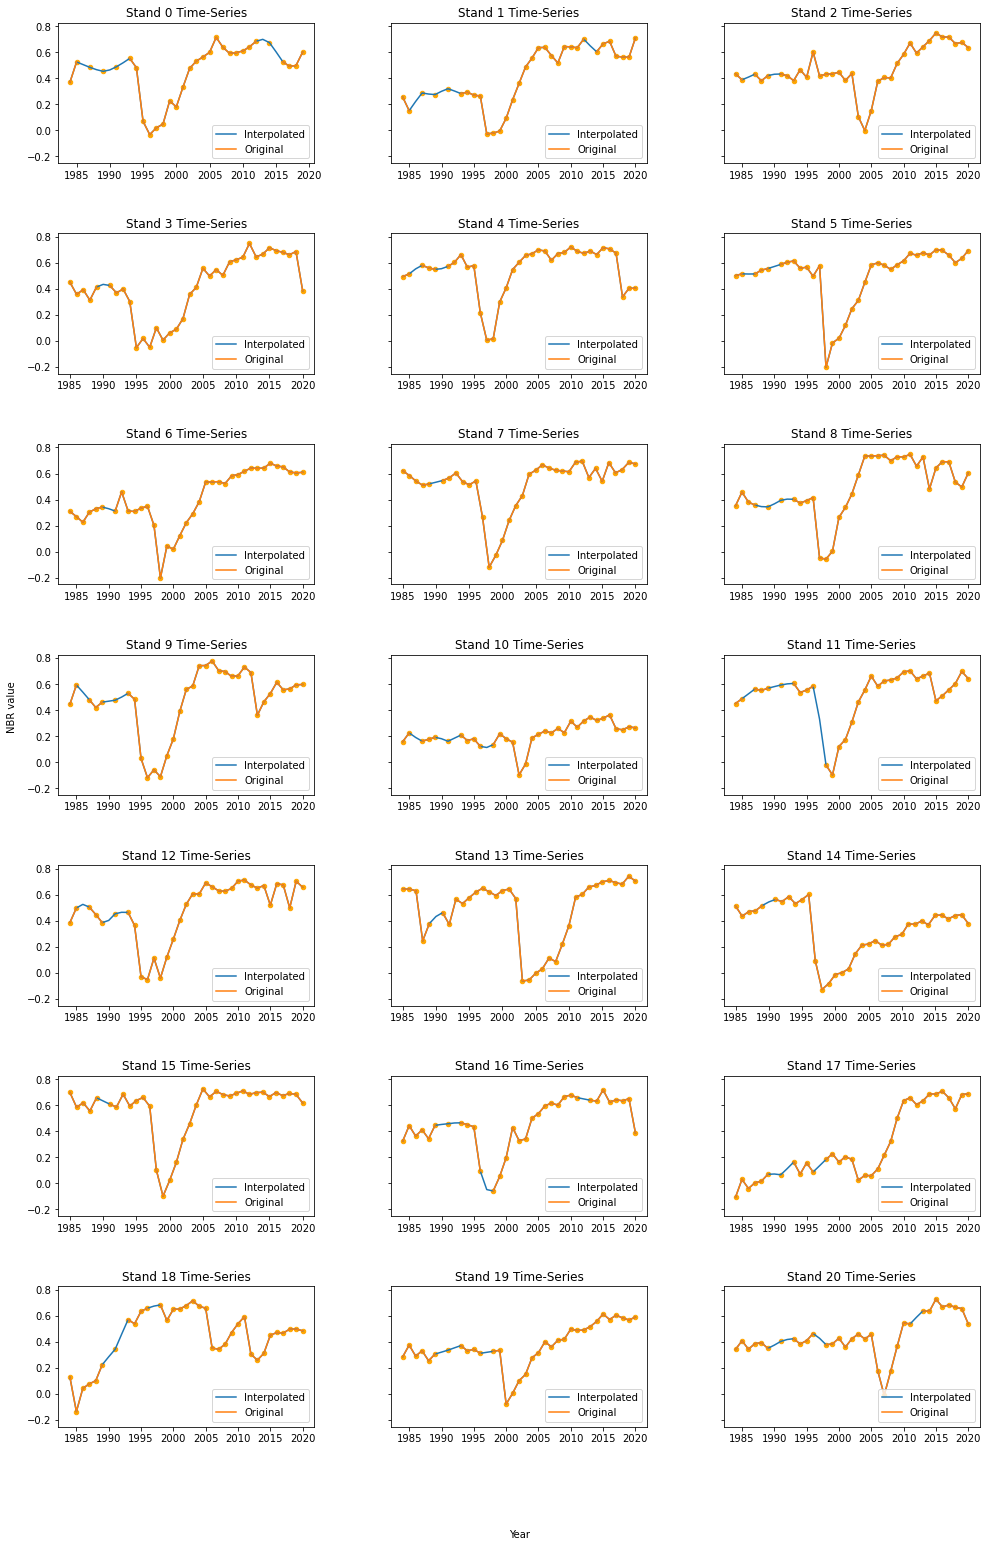

In [25]:
%matplotlib inline
import scipy as sp
import scipy.signal as scisig

# interpolation of null values
plotDF = NDVItsDF.interpolate(axis = 'columns',method = 'akima')

# setting up for time-series plots
fig, axs = plt.subplots(7, 3, sharex=False, sharey=True, figsize = (16,25))

for i, ax in enumerate(fig.axes):
    ax.plot(plotDF.iloc[i,].transpose(),label = "Interpolated")
    ax.plot(NDVItsDF.iloc[i,].transpose(),label = "Original")
    ax.scatter(imageYears,NDVItsDF.iloc[i,], color = 'orange',s = 20)
    ax.legend(loc='lower right')
    ax.set_title("Stand"+' '+str(i)+' '+"Time-Series")
    
fig.subplots_adjust(left=0.1, bottom=0.1, right=None, top=None, wspace=0.3, hspace=0.5)
fig.text(0.5, 0.04, 'Year', ha='center', va='center')
fig.text(0.06, 0.5, (outputIndex+' '+'value'), ha='center', va='center', rotation='vertical')

fig.savefig("C:/R_workspace/timeSeries_interpolation.svg")

In [24]:
plotDF

plotDF.to_csv(path_or_buf="C:/R_workspace/timeSeriesDF500_4.csv", sep=',', na_rep='', float_format=None, header=True, index=True, mode='w')